# Model Training and Testing

In this file, we train each of our models on the exact same training dataset, and test them
on the same testing dataset. This allows us to judge their performance, strengths, and
weaknesses using a comparable measure. We hope that this will, in conjunction with our
hypotheses, help us understand the merits of each model, and be more informed in future
instances of model selection.

## Imports

In [83]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.metrics import precision_recall_fscore_support as class_metrics
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import pickle
pd.set_option('display.max_columns', None)

## Create the Dataset

First, we separate out the testing and training dataset for each of our models to train on.
In this case, we decided against k-cross validation due to the sheer size of our dataset.
The accuracy of our models should be representative of their performance on future data as
well, since there is such a large quantity of training data.

Our dataset does have a few issues: several of the variables have classes which occur very infrequently.
This may bias our results, since we don't know much about how that variable affects heart disease relative to the other
classes. Therefore, we may need to stratify our data to get more accurate results.
Additionally, the columns **GenHealth** and **Stroke** have the potential to bias our results.
These factors are much more likely to occur due to heart disease, but may not be a good predictor
of its future fruition. Therefore, to deal with each of these issues, we will make separate versions of our dataset for
each of these cases: **Normal**, **Stratified**, and **No Health Indicators**.

In [45]:
# Import the dataset
data = pd.read_csv('raw_data.csv')

# Create a lists of each type of feature
nominal_features = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'Race', 'Diabetic',
                  'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']
ordinal_features = ['AgeCategory', 'GenHealth']
continuous_features = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

# region Convert the nominal features into one-hot encodings

# Create a One-Hot Encoder
encoder = OneHotEncoder()

# For each nominal feature...
for feature in nominal_features:

    # Get an encoded version
    encoded_feature = pd.DataFrame(encoder.fit_transform(data[[feature]]).toarray(),
                                   columns=[f'{feature}_{f_class}' for f_class in data[feature].unique()])

    # Remove the old feature from the data
    data = data.drop(feature, axis=1)

    # Add the encoded feature to the data
    data = data.join(encoded_feature)

# endregion Convert the nominal features into one-hot encodings

# region Convert the ordinal features into labels

# For each nominal feature...
for feature in ordinal_features:

    # Replace the old feature with an encoded feature
    data[feature] = data[feature].astype('category').cat.codes

# endregion Convert the ordinal features into labels

# Convert the output column to be numerical
data['HeartDisease'] = data['HeartDisease'].astype('category').cat.codes

# Get the X and y of the dataset
data_X = data.iloc[:,1:]
data_y = data.loc[:,'HeartDisease']

# Display the head of the data
print("Rows:    ", data.shape[0])
print("Columns: ", data.shape[1])
data.head()

Rows:     319795
Columns:  35


,HeartDisease,BMI,PhysicalHealth,MentalHealth,AgeCategory,GenHealth,SleepTime,Smoking_Yes,Smoking_No,AlcoholDrinking_No,...,"Diabetic_No, borderline diabetes",Diabetic_Yes (during pregnancy),PhysicalActivity_Yes,PhysicalActivity_No,Asthma_Yes,Asthma_No,KidneyDisease_No,KidneyDisease_Yes,SkinCancer_Yes,SkinCancer_No
0,0,16.60,3.0,30.0,7,4,5.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1,0,20.34,0.0,0.0,12,4,7.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0,26.58,20.0,30.0,9,1,8.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0,24.21,0.0,0.0,11,2,6.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0,23.71,28.0,0.0,4,4,8.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [46]:
# Get the Normal test-train split
normal_train_X, normal_test_X, normal_train_y, normal_test_y = train_test_split(data_X, data_y, train_size=2/3,
                                                                                random_state=42)

# Get the Stratified test-train split
stratified_train_X, stratified_test_X, stratified_train_y, stratified_test_y = train_test_split(data_X, data_y,
                                                                                                train_size=2/3,
                                                                                                stratify=data_y,
                                                                                                random_state=42)
# Get the No Health test-train split
dropped_features = [feature for feature in data.columns if ('GenHealth' in feature or 'Stroke' in feature) and feature in data_X.columns]
nohealth_train_X, nohealth_test_X, nohealth_train_y, nohealth_test_y = train_test_split(data_X.drop(dropped_features,
                                                                                                    axis=1),
                                                                                        data_y, train_size=2/3,
                                                                                        random_state=42)

## Dataset Tuning

Now that we know have our datasets, we need to find which we want to use. To do that, we can introduce a simple model
which we will use as a measure. By comparing the results of the model trained on each of the different datasets, we
can get a sense of how the changes impact performance, and potentially help us intuit whether any bias is introduced by
our data. In specific, we are looking to see if the dropped data columns or the stratification make the dataset perform
better or worse.

The model we will be using for this is **Logistic Regression**, since this model is very simple and fast to train.

In [84]:
# Create a standard scalar and one-hot-encoding pipeline for each dataset
normal_pipe = Pipeline([('scalar', StandardScaler()), ('lr', LogisticRegression())])
stratified_pipe = Pipeline([('scalar', StandardScaler()), ('lr', LogisticRegression())])
nohealth_pipe = Pipeline([('scalar', StandardScaler()), ('lr', LogisticRegression())])

# Train each logistic regression on its dataset
normal_pipe.fit(normal_train_X, normal_train_y)
stratified_pipe.fit(stratified_train_X, stratified_train_y)
nohealth_pipe.fit(nohealth_train_X, nohealth_train_y)

# Make predictions with each logistic regression
normal_prediction = normal_pipe.predict(normal_test_X)
stratified_prediction = stratified_pipe.predict(stratified_test_X)
nohealth_prediction = nohealth_pipe.predict(nohealth_test_X)

# Find the score of each regression
normal_precision, normal_recall, normal_f, _ = class_metrics(normal_test_y, normal_prediction)
stratified_precision, stratified_recall, stratified_f, _ = class_metrics(stratified_test_y, stratified_prediction)
nohealth_precision, nohealth_recall, nohealth_f, _ = class_metrics(nohealth_test_y, nohealth_prediction)

# Display the score of each regression
print("Normal Dataset LR:")
print(f"Precision: {normal_precision[1]}")
print(f"Recall:    {normal_recall[1]}")
print(f"F1 Score:  {normal_f[1]}")
print()
print("Stratified Dataset LR:")
print(f"Precision: {stratified_precision[1]}")
print(f"Recall:    {stratified_recall[1]}")
print(f"F1 Score:  {stratified_f[1]}")
print()
print("No Health Dataset LR:")
print(f"Precision: {nohealth_precision[1]}")
print(f"Recall:    {nohealth_recall[1]}")
print(f"F1 Score:  {nohealth_f[1]}")

Normal Dataset LR:
Precision: 0.5112219451371571
Recall:    0.08886962176221957
F1 Score:  0.15141722832610102

Stratified Dataset LR:
Precision: 0.5166767738023045
Recall:    0.0933800964489259
F1 Score:  0.15817321080478977

No Health Dataset LR:
Precision: 0.4827018121911038
Recall:    0.06350926628373252
F1 Score:  0.11224978450340006


As we can see, the stratified dataset performed marginally better than the normal dataset, whereas the No Health
indicators dataset performed moderately worse. If were really trying to predict heart disease, this would indicate to
us that using these columns may be unhelpful for our predictions. However, since that is not the case and since we have
the data, we are going to use it anyways, and keep with the stratified dataset.

However, some of our models may need a smaller subset of the data, such as the Gaussian Process Classifier. This is
because they have high memory demands which scale with the data.

Below, let's do two things: Relabel the stratified dataset we'll be using to be more simple, and create a subset of that
dataset for models which need less data

In [47]:
# Rename the stratified dataset
train_X, test_X, train_y, test_y = stratified_train_X, stratified_test_X, stratified_train_y, stratified_test_y

# Get a smaller subset of the dataset
data_subset = data.sample(5000, random_state=42)
data_sub_X = data_subset.iloc[:,1:]
data_sub_y = data_subset.loc[:,'HeartDisease']

# Get the Stratified test-train split
train_sub_X, test_sub_X, train_sub_y, test_sub_y = train_test_split(data_sub_X, data_sub_y, train_size=2/3,
                                                                    stratify=data_sub_y, random_state=42)

# Model Training

Now, we need to train each of our models on the stratified data. Since our training dataset is so large (around
200,000 samples), we do not need to cross validate our results for each model - they should be representative of true
performance relative to one another.

Let's start by defining some methods that makes sure that each of our models is trained the same general way.

In [48]:
def train_model(model, parameter_dict, dataset_train_x, dataset_train_y):
    """This function is used to the find the best model using Cross Validating grid search.
    It also applies a standard scaling pipeline to the data.

    :param model: An SK Learn model to train
    :param parameter_dict: A dictionary of parameters to optimize using grid search. Keys are non-pipe parameters.
    :param dataset_train_x: The X values of the training dataset
    :param dataset_train_y: The y values of the training dataset
    :return best_model: The best model found by the grid search, retrained on all of the data
    :return search: The grid search object
    """

    # Create the pipeline
    pipe = Pipeline([('scalar', StandardScaler()), ('model', model)])

    # Find the parameter grid
    parameter_grid = {'model__' + param: parameter_dict[param] for param in parameter_dict}

    # Get the GridSearch object
    search = GridSearchCV(pipe, parameter_grid, cv=3, n_jobs=-1, verbose=100, scoring='f1')

    # Search for the best model
    search.fit(dataset_train_x, dataset_train_y)

    # Train the best model found
    best_model = Pipeline([('scalar', StandardScaler()), ('model', model)]).set_params(**search.best_params_)
    best_model.fit(dataset_train_x, dataset_train_y)

    # Return the grid search object
    return best_model, search


def display_results(model_name, best_model, grid_search, dataset_train_x, dataset_train_y,
                    dataset_test_x, dataset_test_y):
    """This function displays the results of the grid search both via tables and graphically.

    :param model_name: The name of the SK Learn model trained
    :param best_model: The best model found by the grid search
    :param grid_search: The grid search object which optimized the model
    :param dataset_train_x: The X values of the training dataset
    :param dataset_train_y: The y values of the training dataset
    :param dataset_test_x: The X values of the training dataset
    :param dataset_test_y: The y values of the training dataset
    """

    # Add spacing
    print("\n")

    # Start by displaying the trend of the data over each of the parameters
    for param in grid_search.best_params_:

        # This dict stores the mean performance for each parameter
        param_dict = {}

        # For the parameter value for each grid search iteration
        for p_ind, p in enumerate(grid_search.cv_results_[f'param_{param}']):

            # Get P's name
            pname = str(p)

            # If the parameter is not in the param dictionary, add it
            if pname not in param_dict: param_dict[pname] = (1, grid_search.cv_results_['mean_test_score'][p_ind])

            # Otherwise, summate them
            else: param_dict[pname] = (param_dict[pname][0] + 1,
                                   param_dict[pname][1] + grid_search.cv_results_['mean_test_score'][p_ind])

        # Finally, find the average value for each parameter value across all grid search iteration
        for p in param_dict:
            pname = str(p)
            param_dict[pname] = param_dict[pname][1] / param_dict[pname][0]

        # If the data is numeric, draw a lineplot
        if type(list(param_dict.keys())[0]) is not str:
            xtick_enum = range(len(list(param_dict.keys())))
            ax = sns.lineplot(x=xtick_enum, y=param_dict.values())
            ax.set_xticks(xtick_enum, list(param_dict.keys()))

        # otherwise, draw a barplot
        else: ax = sns.barplot(x=list(param_dict.keys()), y=list(param_dict.values()))

        # Since we only care about the differences between models, zoom in the plot to see the differences
        max_val = max(param_dict.values())
        min_val = min(param_dict.values())
        range_val = max_val - min_val
        plt.ylim(min_val - range_val*0.1, max_val + range_val*0.1)

        # Add plot aesthetics
        ax.set_xlabel(param[7:].capitalize() + ' Value')
        ax.set_ylabel('F1 Score')
        plt.title(f'F1 Score over {param[7:].capitalize()} Value')
        plt.show()

    # Calculate the performance of the best model
    model_train_pred = best_model.predict(dataset_train_x)
    model_test_pred = best_model.predict(dataset_test_x)

    # Calculate the performance metrics of the best model
    model_train_precision, model_train_recall, model_train_f1, _ = class_metrics(dataset_train_y, model_train_pred,
                                                                                 zero_division=0)
    model_test_precision, model_test_recall, model_test_f1, _ = class_metrics(dataset_test_y, model_test_pred,
                                                                              zero_division=0)

    # Display which parameters were best
    print("The best parameters were:")
    for param in grid_search.best_params_:
        print(re.search(r'model__(.*)', param).group(1) + f": {grid_search.best_params_[param]}")
    print("\n")

    # Display the scores of the best model
    print(f"{model_name.title()} Prediction Metrics:")
    print(f"Train Precision: {model_train_precision[1]}")
    print(f"Train Recall:    {model_train_recall[1]}")
    print(f"Train F1 Score:  {model_train_f1[1]}")
    print(f"Test Precision:  {model_test_precision[1]}")
    print(f"Test Recall:     {model_test_recall[1]}")
    print(f"Test F1 Score:   {model_test_f1[1]}")


def save_model(model_name, grid_search):
    """Save the best model's parameters.

    :param model_name: The name of the SK Learn model trained
    :param grid_search: The grid search object which optimized the model
    """

    pickle.dump(grid_search.best_params_, open(f'../models/{model_name}.pkl', 'wb'))

## Baseline Model

A good place to start is to make a baseline. The most simple baseline model we can use is one that always guesses that there is heart disease. Let's see how this performs, in order to compare it to our other models.

In [85]:
# Create a dataframe full of 'Yes' Heart Disease Predictions
baseline_train_pred = pd.Series([1] * train_y.shape[0])
baseline_test_pred = pd.Series([1] * test_y.shape[0])

# Find the baseline classification metrics
baseline_train_precision, baseline_train_recall, baseline_train_f, _ = class_metrics(train_y,
                                                                                     baseline_train_pred,
                                                                                     zero_division=0)
baseline_test_precision, baseline_test_recall, baseline_test_f, _ = class_metrics(test_y,
                                                                                  baseline_test_pred,
                                                                                  zero_division=0)

# Display the score of each regression
print("Baseline Model Prediction Metrics:")
print(f"Train Precision: {baseline_train_precision[1]}")
print(f"Train Recall:    {baseline_train_recall[1]}")
print(f"Train F1 Score:  {baseline_train_f[1]}")
print(f"Test Precision:  {baseline_test_precision[1]}")
print(f"Test Recall:     {baseline_test_recall[1]}")
print(f"Test F1 Score:   {baseline_test_f[1]}")

Baseline Model Prediction Metrics:
Train Precision: 0.08559729075592412
Train Recall:    1.0
Train F1 Score:  0.15769621292315666
Test Precision:  0.08559179729640991
Test Recall:     1.0
Test F1 Score:   0.15768689024653698


As we can see, our model does pretty poorly overall. Although it does correctly label all occurrences of heart disease,
it fails to label any of the negative cases. Our F Score to beat comes out to be **0.159**.

## Logistic Regression

### Logistic Regression w/ Polynomial Features

I want to explore how the model runs with different degrees of polynomial logistic regression, including linear, by using the sklearn pre-processing feature PolynomialFeatures. So first, I want to create and store different sets of the data that's been transformed on different degrees that can they all be run through the logistic regression model and compared.

In [11]:
poly_train= []
poly_test = []
for d in range(1,5):
    trans_tr = PolynomialFeatures(degree=d)
    trans_te = PolynomialFeatures(degree=d)
    poly_train.append(np.array(trans_tr.fit_transform(train_sub_X)))
    poly_test.append(np.array(trans_te.fit_transform(test_sub_X)))
with open('train_PolyFeatures', 'wb') as f:
    pickle.dump(poly_train, f)
with open('test_PolyFeatures', 'wb') as f:
    pickle.dump(poly_test, f)

I would have liked to explore models with a higher degree of polynomial, but memory limitations stopped me at a degree of 4.

In [6]:
with open('test_PolyFeatures', 'rb') as f:
    poly_test_X = pickle.load(f)
with open('train_PolyFeatures', 'rb') as f:
    poly_train_X = pickle.load(f)

First, I wanted to see how the model performed with the default parameters provided by sklearn which I could then more easily compare to see how much the hypertuning improves performance.

In [62]:
no_params = {}

In [57]:
lr_model = LogisticRegression(max_iter=200, random_state=42)
for i in range(3):
    bm, gs = train_model(lr_model, no_params, poly_train_X[i], train_sub_y)
    filename = 'models/PF' + str(i+1) + '_C1'
    with open(filename, 'wb') as f:
        pickle.dump(bm, f)
    filename = filename + '_gs'
    with open(filename, 'wb') as f:
        pickle.dump(gs, f)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

#### Polynomial Features, Degree = 1-3, tol = 1e-4, no hyperparameter tuning

In [63]:
for i in range(3):
    filename = 'models/PF' + str(i+1) + '_C1'
    with open(filename, 'rb') as f:
        bm = pickle.load(f)
    filename = 'models/PF' + str(i+1) + '_C1_gs'
    with open(filename, 'rb') as f:
        gs = pickle.load(f)
    display_results("Logistic Regression w/ PF D=" + str(i+1), bm, gs, poly_train_X[i], train_sub_y, poly_test_X[i], test_sub_y)



The best parameters were:


Logistic Regression W/ Pf D=1 Prediction Metrics:
Train Precision: 0.5471698113207547
Train Recall:    0.0926517571884984
Train F1 Score:  0.15846994535519127
Test Precision:  0.3333333333333333
Test Recall:     0.07051282051282051
Test F1 Score:   0.1164021164021164


The best parameters were:


Logistic Regression W/ Pf D=2 Prediction Metrics:
Train Precision: 0.7431192660550459
Train Recall:    0.25878594249201275
Train F1 Score:  0.38388625592417064
Test Precision:  0.23529411764705882
Test Recall:     0.07692307692307693
Test F1 Score:   0.11594202898550726


The best parameters were:


Logistic Regression W/ Pf D=3 Prediction Metrics:
Train Precision: 0.9567099567099567
Train Recall:    0.7060702875399361
Train F1 Score:  0.8124999999999999
Test Precision:  0.226890756302521
Test Recall:     0.17307692307692307
Test F1 Score:   0.19636363636363635


Using the default parameters for Logistic Regression, theres clearly issues with converging and the test performance is very low, especially compared to testing performance, for all 3 degrees. It would be wise to hypertune and find the best parameters for our model. Degree 3 does give the best f1 + recall scores.

Then, I created a dictionary for hyperparameters to compare with gridsearch and find the best model for each degree of polynomial. The lr_params are used for finding the best model for degrees 1-3. I also explored the model using different values of 'tol', the stopping criteria, for each set of degrees. I didn't put this in the param dictionary for gridsearch because I wanted to be able to visualize the difference in performance, as it's merely to help it converge within the processing limits (as it'd be expensive to hypertune more parameters) and won't necessarily produce the best performance for that set of parameters at that degree.

The no_params dictionary is for running the model with a degree of 4, as trying to gridsearch with it crashes the kernel due to memory consumption.

In [64]:
lr_params = {'solver': ['sag', 'saga'],
             'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
             'class_weight': [None, 'balanced']}

For each tol value, I ran model selection and displayed the results of the best performing model, based on the tests above, for 1-3 degrees of polynomial regression.

In [14]:
lr_model = LogisticRegression(max_iter=200, random_state=42, tol=1e-4)
for i in range(3):
    bm, gs = train_model(lr_model, lr_params, poly_train_X[i], train_sub_y)
    filename = 'models/tol_1e-4/PF' + str(i+1)
    with open(filename, 'wb') as f:
        pickle.dump(bm, f)
    filename = 'models/tol_1e-4/PF' + str(i+1) + '_gs'
    with open(filename, 'wb') as f:
        pickle.dump(gs, f)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 2/3; 1/24] START model__C=1e-05, model__class_weight=None, model__solver=sag
[CV 2/3; 1/24] END model__C=1e-05, model__class_weight=None, model__solver=sag;, score=0.000 total time=   0.0s
[CV 2/3; 12/24] START model__C=0.001, model__class_weight=balanced, model__solver=saga
[CV 2/3; 12/24] END model__C=0.001, model__class_weight=balanced, model__solver=saga;, score=0.338 total time=   0.0s
[CV 3/3; 12/24] START model__C=0.001, model__class_weight=balanced, model__solver=saga
[CV 3/3; 12/24] END model__C=0.001, model__class_weight=balanced, model__solver=saga;, score=0.331 total time=   0.0s
[CV 2/3; 14/24] START model__C=0.01, model__class_weight=None, model__solver=saga
[CV 2/3; 14/24] END model__C=0.01, model__class_weight=None, model__solver=saga;, score=0.090 total time=   0.0s
[CV 3/3; 14/24] START model__C=0.01, model__class_weight=None, model__solver=saga
[CV 3/3; 14/24] END model__C=0.01, model__class_weight=None

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 1/3; 2/24] START model__C=1e-05, model__class_weight=None, model__solver=saga
[CV 1/3; 2/24] END model__C=1e-05, model__class_weight=None, model__solver=saga;, score=0.000 total time=   0.0s
[CV 1/3; 13/24] START model__C=0.01, model__class_weight=None, model__solver=sag
[CV 1/3; 13/24] END model__C=0.01, model__class_weight=None, model__solver=sag;, score=0.036 total time=   0.0s
[CV 2/3; 13/24] START model__C=0.01, model__class_weight=None, model__solver=sag
[CV 2/3; 13/24] END model__C=0.01, model__class_weight=None, model__solver=sag;, score=0.090 total time=   0.0s
[CV 3/3; 15/24] START model__C=0.01, model__class_weight=balanced, model__solver=sag
[CV 3/3; 15/24] END model__C=0.01, model__class_weight=balanced, model__solver=sag;, score=0.310 total time=   0.0s
[CV 1/3; 16/24] START model__C=0.01, model__class_weight=balanced, model__solver=saga
[CV 1/3; 16/24] END model__C=0.01, model__class_weight=balanced, model__solver=saga;, score=0.350 total time=   0.0s
[CV 3/3; 19/24]

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

[CV 3/3; 1/24] START model__C=1e-05, model__class_weight=None, model__solver=sag
[CV 3/3; 1/24] END model__C=1e-05, model__class_weight=None, model__solver=sag;, score=0.000 total time=   0.0s
[CV 3/3; 17/24] START model__C=0.1, model__class_weight=None, model__solver=sag.
[CV 3/3; 17/24] END model__C=0.1, model__class_weight=None, model__solver=sag;, score=0.203 total time=   0.0s
[CV 1/3; 18/24] START model__C=0.1, model__class_weight=None, model__solver=saga
[CV 1/3; 18/24] END model__C=0.1, model__class_weight=None, model__solver=saga;, score=0.083 total time=   0.0s
[CV 2/3; 22/24] START model__C=1, model__class_weight=None, model__solver=saga..
[CV 2/3; 22/24] END model__C=1, model__class_weight=None, model__solver=saga;, score=0.136 total time=   0.0s
[CV 3/3; 22/24] START model__C=1, model__class_weight=None, model__solver=saga..
[CV 3/3; 22/24] END model__C=1, model__class_weight=None, model__solver=saga;, score=0.214 total time=   0.0s
[CV 3/3; 23/24] START model__C=1, model_

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 3/3; 2/24] START model__C=1e-05, model__class_weight=None, model__solver=saga
[CV 3/3; 2/24] END model__C=1e-05, model__class_weight=None, model__solver=saga;, score=0.000 total time=   0.0s
[CV 2/3; 18/24] START model__C=0.1, model__class_weight=None, model__solver=saga
[CV 2/3; 18/24] END model__C=0.1, model__class_weight=None, model__solver=saga;, score=0.137 total time=   0.0s
[CV 3/3; 18/24] START model__C=0.1, model__class_weight=None, model__solver=saga
[CV 3/3; 18/24] END model__C=0.1, model__class_weight=None, model__solver=saga;, score=0.203 total time=   0.0s
[CV 3/3; 21/24] START model__C=1, model__class_weight=None, model__solver=sag...
[CV 3/3; 21/24] END model__C=1, model__class_weight=None, model__solver=sag;, score=0.214 total time=   0.0s
[CV 1/3; 22/24] START model__C=1, model__class_weight=None, model__solver=saga..
[CV 1/3; 22/24] END model__C=1, model__class_weight=None, model__solver=saga;, score=0.

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV 2/3; 2/24] START model__C=1e-05, model__class_weight=None, model__solver=saga
[CV 2/3; 2/24] END model__C=1e-05, model__class_weight=None, model__solver=saga;, score=0.000 total time=   0.0s
[CV 1/3; 17/24] START model__C=0.1, model__class_weight=None, model__solver=sag.
[CV 1/3; 17/24] END model__C=0.1, model__class_weight=None, model__solver=sag;, score=0.083 total time=   0.0s
[CV 2/3; 17/24] START model__C=0.1, model__class_weight=None, model__solver=sag.
[CV 2/3; 17/24] END model__C=0.1, model__class_weight=None, model__solver=sag;, score=0.137 total time=   0.0s
[CV 1/3; 21/24] START model__C=1, model__class_weight=None, model__solver=sag...
[CV 1/3; 21/24] END model__C=1, model__class_weight=None, model__solver=sag;, score=0.082 total time=   0.0s
[CV 2/3; 21/24] START model__C=1, model__class_weight=None, model__solver=sag...
[CV 2/3; 21/24] END model__C=1, model__class_weight=None, model__solver=sag;, score=0.134 total time=   0.0s
[CV 2/3; 23/24] START model__C=1, model__

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

[CV 2/3; 3/24] START model__C=1e-05, model__class_weight=balanced, model__solver=sag
[CV 2/3; 3/24] END model__C=1e-05, model__class_weight=balanced, model__solver=sag;, score=0.318 total time=   0.0s
[CV 3/3; 1/24] START model__C=1e-05, model__class_weight=None, model__solver=sag
[CV 3/3; 1/24] END model__C=1e-05, model__class_weight=None, model__solver=sag;, score=0.000 total time=   0.2s
[CV 3/3; 4/24] START model__C=1e-05, model__class_weight=balanced, model__solver=saga
[CV 3/3; 4/24] END model__C=1e-05, model__class_weight=balanced, model__solver=saga;, score=0.324 total time=   0.2s
[CV 1/3; 6/24] START model__C=0.0001, model__class_weight=None, model__solver=saga
[CV 1/3; 6/24] END model__C=0.0001, model__class_weight=None, model__solver=saga;, score=0.000 total time=   0.4s
[CV 1/3; 9/24] START model__C=0.001, model__class_weight=None, model__solver=sag
[CV 1/3; 9/24] END model__C=0.001, model__class_weight=None, model__solver=sag;, score=0.053 total time=   0.3s
[CV 3/3; 11/2

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

[CV 1/3; 3/24] START model__C=1e-05, model__class_weight=balanced, model__solver=sag
[CV 1/3; 3/24] END model__C=1e-05, model__class_weight=balanced, model__solver=sag;, score=0.314 total time=   0.0s
[CV 2/3; 24/24] START model__C=1, model__class_weight=balanced, model__solver=saga
[CV 2/3; 24/24] END model__C=1, model__class_weight=balanced, model__solver=saga;, score=0.361 total time=   0.1s
[CV 3/3; 2/24] START model__C=1e-05, model__class_weight=None, model__solver=saga
[CV 3/3; 2/24] END model__C=1e-05, model__class_weight=None, model__solver=saga;, score=0.000 total time=   0.6s
[CV 3/3; 7/24] START model__C=0.0001, model__class_weight=balanced, model__solver=sag
[CV 3/3; 7/24] END model__C=0.0001, model__class_weight=balanced, model__solver=sag;, score=0.318 total time=   0.2s
[CV 2/3; 10/24] START model__C=0.001, model__class_weight=None, model__solver=saga
[CV 2/3; 10/24] END model__C=0.001, model__class_weight=None, model__solver=saga;, score=0.103 total time=   0.5s
[CV 1/3

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

#### Polynomial Features, Degree = 1-3, tol = 1e-4, Best Model

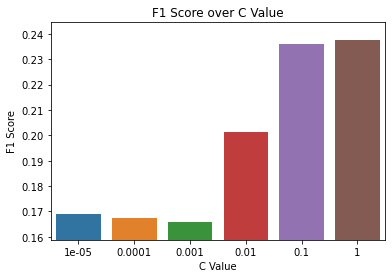

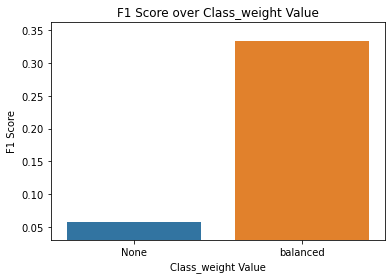

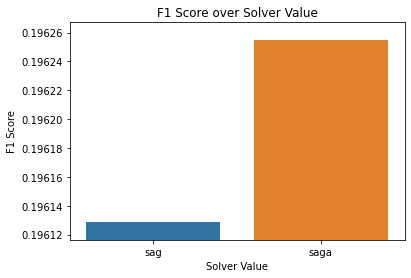

The best parameters were:
C: 1e-05
class_weight: balanced
solver: sag


Logistic Regression W/ Pf D=1 Prediction Metrics:
Train Precision: 0.23809523809523808
Train Recall:    0.5910543130990416
Train F1 Score:  0.33944954128440363
Test Precision:  0.22857142857142856
Test Recall:     0.5641025641025641
Test F1 Score:   0.3253234750462107




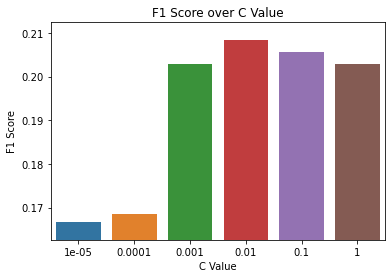

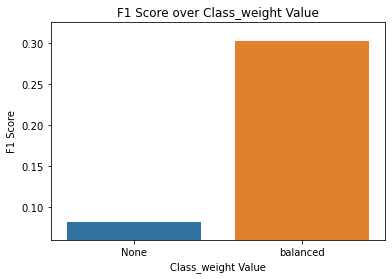

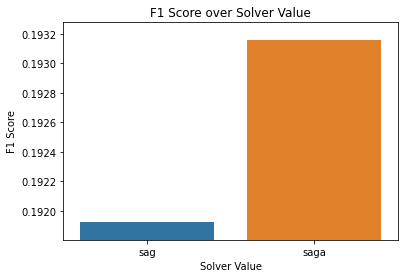

The best parameters were:
C: 0.0001
class_weight: balanced
solver: sag


Logistic Regression W/ Pf D=2 Prediction Metrics:
Train Precision: 0.23917748917748918
Train Recall:    0.7060702875399361
Train F1 Score:  0.35731608730800324
Test Precision:  0.22975929978118162
Test Recall:     0.6730769230769231
Test F1 Score:   0.3425774877650898




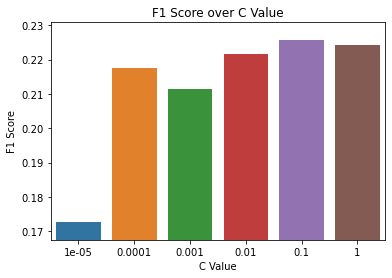

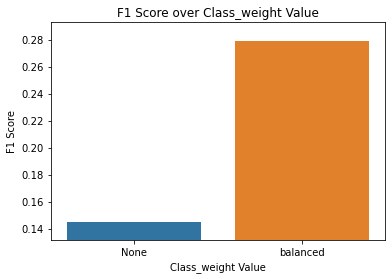

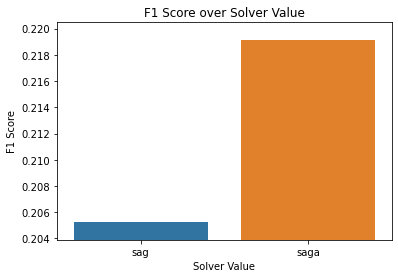

The best parameters were:
C: 1e-05
class_weight: balanced
solver: saga


Logistic Regression W/ Pf D=3 Prediction Metrics:
Train Precision: 0.2316950852557673
Train Recall:    0.7380191693290735
Train F1 Score:  0.3526717557251908
Test Precision:  0.21414141414141413
Test Recall:     0.6794871794871795
Test F1 Score:   0.325652841781874


In [13]:
for i in range(3):
    filename = 'models/tol_1e-4/PF' + str(i+1)
    with open(filename, 'rb') as f:
        bm = pickle.load(f)
    filename = 'models/tol_1e-4/PF' + str(i+1) + '_gs'
    with open(filename, 'rb') as f:
        gs = pickle.load(f)
    display_results("Logistic Regression w/ PF D=" + str(i+1), bm, gs, poly_train_X[i], train_sub_y, poly_test_X[i], test_sub_y)

Tuning various hyperparameters clearly improves all of the models significantly, all of the best models using 'saga' as the solver and 'balanced' for the class_weights. Both higher degrees performed better than just the linear model, with the polynomial of degree 2 performing the best using C of 1e-4. Its interesting to note they perform best with slightly differing C values but all much lower than the default 1. There was still a fair amount of issues with some models not converging, so trying a higher tol value might help.

In [15]:
lr_model = LogisticRegression(max_iter=200, random_state=42, tol=1e-3)
for i in range(3):
    bm, gs = train_model(lr_model, lr_params, poly_train_X[i], train_sub_y)
    filename = 'models/tol_1e-3/PF' + str(i+1)
    with open(filename, 'wb') as f:
        pickle.dump(bm, f)
    filename = 'models/tol_1e-3/PF' + str(i+1) + '_gs'
    with open(filename, 'wb') as f:
        pickle.dump(gs, f)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3; 2/24] START model__C=1e-05, model__class_weight=None, model__solver=saga
[CV 1/3; 2/24] END model__C=1e-05, model__class_weight=None, model__solver=saga;, score=0.318 total time=   2.8s
[CV 1/3; 5/24] START model__C=0.0001, model__class_weight=None, model__solver=sag
[CV 1/3; 5/24] END model__C=0.0001, model__class_weight=None, model__solver=sag;, score=0.260 total time=   3.0s
[CV 2/3; 7/24] START model__C=0.0001, model__class_weight=balanced, model__solver=sag
[CV 2/3; 7/24] END model__C=0.0001, model__class_weight=balanced, model__solver=sag;, score=0.330 total time=   3.6s
[CV 1/3; 10/24] START model__C=0.001, model__class_weight=None, model__solver=saga
[CV 1/3; 10/24] END model__C=0.001, model__class_weight=None, model__solver=saga;, score=0.238 total time=   8.4s
[CV 1/3; 13/24] START model__C=0.01, model__class_weight=None, model__solver=sag
[CV 1/3; 13/24] END model__C=0.01, model__class_weight=None, model__

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

[CV 1/3; 11/24] START model__C=0.001, model__class_weight=balanced, model__solver=sag
[CV 1/3; 11/24] END model__C=0.001, model__class_weight=balanced, model__solver=sag;, score=0.336 total time=   0.5s
[CV 2/3; 12/24] START model__C=0.001, model__class_weight=balanced, model__solver=saga
[CV 2/3; 12/24] END model__C=0.001, model__class_weight=balanced, model__solver=saga;, score=0.335 total time=   1.8s
[CV 1/3; 14/24] START model__C=0.01, model__class_weight=None, model__solver=saga
[CV 1/3; 14/24] END model__C=0.01, model__class_weight=None, model__solver=saga;, score=0.047 total time=   3.1s
[CV 3/3; 17/24] START model__C=0.1, model__class_weight=None, model__solver=sag.
[CV 3/3; 17/24] END model__C=0.1, model__class_weight=None, model__solver=sag;, score=0.194 total time=   2.9s
[CV 2/3; 20/24] START model__C=0.1, model__class_weight=balanced, model__solver=saga
[CV 2/3; 20/24] END model__C=0.1, model__class_weight=balanced, model__solver=saga;, score=0.289 total time=   3.2s
[CV 

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

#### Polynomial Features, Degree = 1-3, tol = 1e-3, Best Model

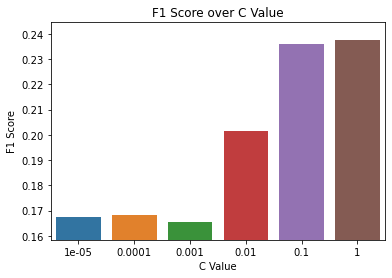

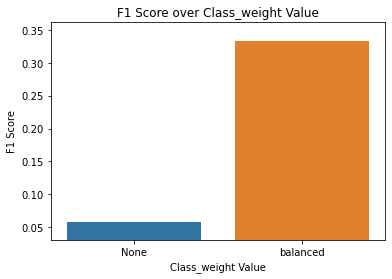

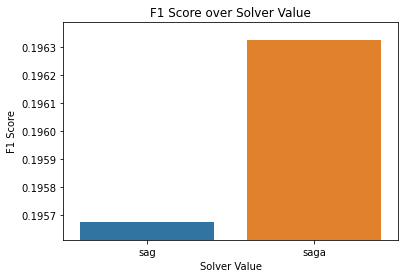

The best parameters were:
C: 0.01
class_weight: balanced
solver: sag


Logistic Regression W/ Pf D=1 Prediction Metrics:
Train Precision: 0.22535211267605634
Train Recall:    0.7667731629392971
Train F1 Score:  0.3483309143686502
Test Precision:  0.20985401459854014
Test Recall:     0.7371794871794872
Test F1 Score:   0.32670454545454547




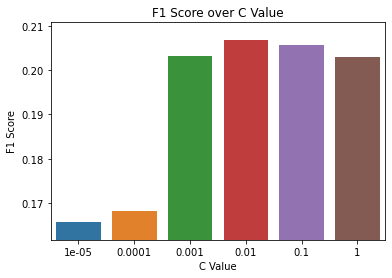

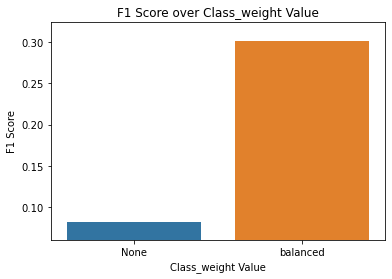

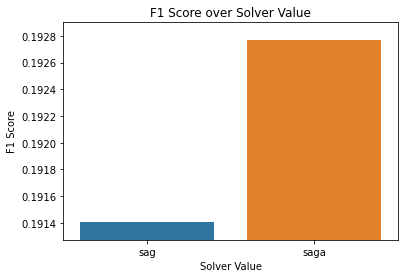

The best parameters were:
C: 0.0001
class_weight: balanced
solver: sag


Logistic Regression W/ Pf D=2 Prediction Metrics:
Train Precision: 0.23917748917748918
Train Recall:    0.7060702875399361
Train F1 Score:  0.35731608730800324
Test Precision:  0.2314410480349345
Test Recall:     0.6794871794871795
Test F1 Score:   0.3452768729641694




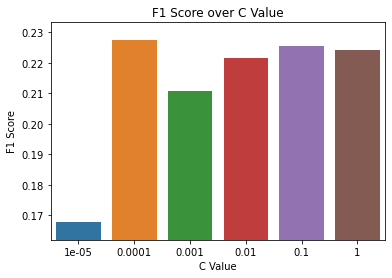

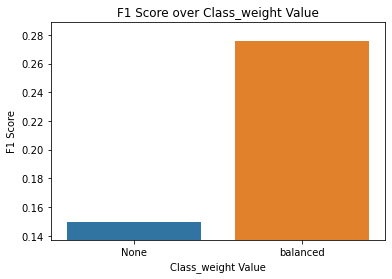

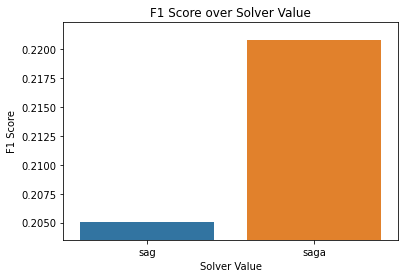

The best parameters were:
C: 1e-05
class_weight: balanced
solver: sag


Logistic Regression W/ Pf D=3 Prediction Metrics:
Train Precision: 0.22602089268755934
Train Recall:    0.7603833865814696
Train F1 Score:  0.3484626647144949
Test Precision:  0.2169811320754717
Test Recall:     0.7371794871794872
Test F1 Score:   0.33527696793002915


In [67]:
for i in range(3):
    filename = 'models/tol_1e-3/PF' + str(i+1)
    with open(filename, 'rb') as f:
        bm = pickle.load(f)
    filename = 'models/tol_1e-3/PF' + str(i+1) + '_gs'
    with open(filename, 'rb') as f:
        gs = pickle.load(f)
    display_results("Logistic Regression w/ PF D=" + str(i+1), bm, gs, poly_train_X[i], train_sub_y, poly_test_X[i], test_sub_y)

Increasing the 'tol' value seemed to improve results for all 3 degrees. The linear model's recall improved by a lot, the 2nd degree poly only increasing slightly for both values, and the 3rd degree increased a fair amount where it's now the best model overall for recall. Degree 2 is still the best for overall accuracy based on it's f1 score for both tol values. As the accuracy is increasing, it might be worthwhile to try one more degree higher of tol value.

In [80]:
lr_model = LogisticRegression(max_iter=200, random_state=42, tol=1e-2)
for i in range(3):
    bm, gs = train_model(lr_model, lr_params, poly_train_X[i], train_sub_y)
    filename = 'models/tol_1e-2/PF' + str(i+1)
    with open(filename, 'wb') as f:
        pickle.dump(bm, f)
    filename = 'models/tol_1e-2/PF' + str(i+1) + '_gs'
    with open(filename, 'wb') as f:
        pickle.dump(gs, f)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV 1/3; 1/24] START model__C=1e-05, model__class_weight=None, model__solver=sag
[CV 1/3; 1/24] END model__C=1e-05, model__class_weight=None, model__solver=sag;, score=0.000 total time=   0.0s
[CV 2/3; 3/24] START model__C=1e-05, model__class_weight=balanced, model__solver=sag
[CV 2/3; 3/24] END model__C=1e-05, model__class_weight=balanced, model__solver=sag;, score=0.318 total time=   0.0s
[CV 3/3; 3/24] START model__C=1e-05, model__class_weight=balanced, model__solver=sag
[CV 3/3; 3/24] END model__C=1e-05, model__class_weight=balanced, model__solver=sag;, score=0.315 total time=   0.0s
[CV 1/3; 4/24] START model__C=1e-05, model__class_weight=balanced, model__solver=saga
[CV 1/3; 4/24] END model__C=1e-05, model__class_weight=balanced, model__solver=saga;, score=0.340 total time=   0.0s
[CV 2/3; 4/24] START model__C=1e-05, model__class_weight=balanced, model__solver

#### Polynomial Features, Degree = 1-3, tol = 1e-2, Best Model

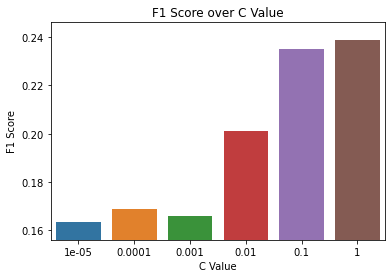

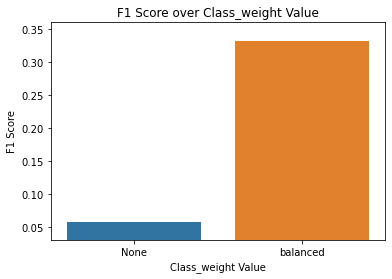

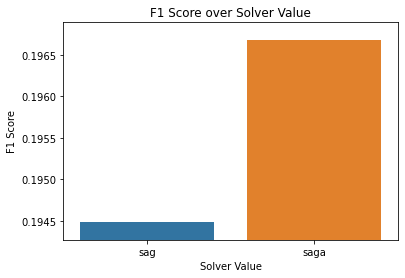

The best parameters were:
C: 0.0001
class_weight: balanced
solver: sag


Logistic Regression W/ Pf D=1 Prediction Metrics:
Train Precision: 0.22904368358913813
Train Recall:    0.6198083067092651
Train F1 Score:  0.3344827586206896
Test Precision:  0.2289156626506024
Test Recall:     0.6089743589743589
Test F1 Score:   0.3327495621716287




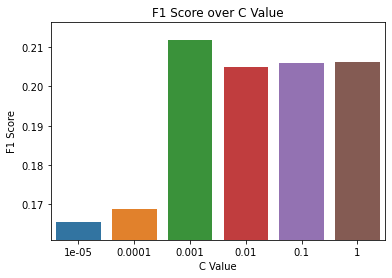

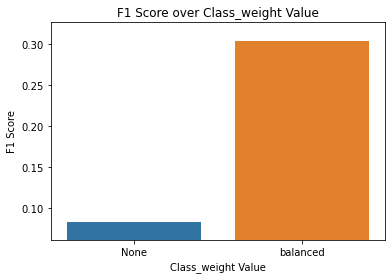

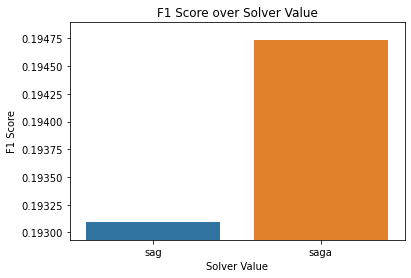

The best parameters were:
C: 0.0001
class_weight: balanced
solver: sag


Logistic Regression W/ Pf D=2 Prediction Metrics:
Train Precision: 0.2374331550802139
Train Recall:    0.7092651757188498
Train F1 Score:  0.3557692307692307
Test Precision:  0.22943722943722944
Test Recall:     0.6794871794871795
Test F1 Score:   0.343042071197411




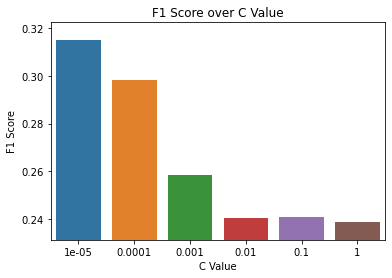

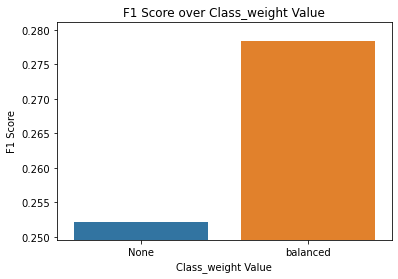

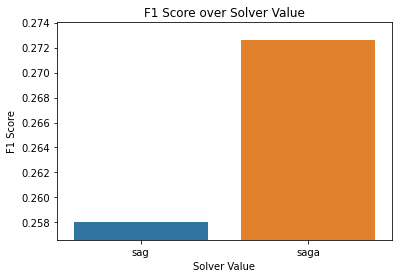

The best parameters were:
C: 1e-05
class_weight: None
solver: saga


Logistic Regression W/ Pf D=3 Prediction Metrics:
Train Precision: 0.2519582245430809
Train Recall:    0.6166134185303515
Train F1 Score:  0.3577386468952734
Test Precision:  0.22955145118733508
Test Recall:     0.5576923076923077
Test F1 Score:   0.3252336448598131


In [65]:
for i in range(3):
    filename = 'models/tol_1e-2/PF' + str(i+1)
    with open(filename, 'rb') as f:
        bm = pickle.load(f)
    filename = 'models/tol_1e-2/PF' + str(i+1) + '_gs'
    with open(filename, 'rb') as f:
        gs = pickle.load(f)
    display_results("Logistic Regression w/ PF D=" + str(i+1), bm, gs, poly_train_X[i], train_sub_y, poly_test_X[i], test_sub_y)

The performances of both degree 1 and 3 models dropped significantly, though in testing and training, degree 2 performance remains about the same regardless. 

Lastly, I tested the peformance of a degree 4 poly model with 3 different values of C, on seperate runs because it crashes using gridsearch. I had to use tol value 1e-2 to prevent crashing as well.

In [76]:
lr_model = LogisticRegression(max_iter=100, solver='sag', class_weight='balanced', random_state=42, tol=1e-2, C=1e-5)
bm, gs = train_model(lr_model, no_params, poly_train_X[3], train_sub_y)
with open('models/PF4_C1e-5', 'wb') as f:
    pickle.dump(bm, f)
with open('models/PF4_C1e-5_gs', 'wb') as f:
    pickle.dump(gs, f)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


#### Polynomial Features, Degree = 4, C = [1,1e-3,1e-5], tol=1e-2

In [82]:
with open('models/PF4_C1', 'rb') as f:
    bm = pickle.load(f)
with open('models/PF4_C1_gs', 'rb') as f:
    gs = pickle.load(f)
display_results("Logistic Regression w/ PF D=4", bm, gs, poly_train_X[3], train_sub_y, poly_test_X[3], test_sub_y)

with open('models/PF4_C1e-3', 'rb') as f:
    bm = pickle.load(f)
with open('models/PF4_C1e-3_gs', 'rb') as f:
    gs = pickle.load(f)
display_results("Logistic Regression w/ PF D=4", bm, gs, poly_train_X[3], train_sub_y, poly_test_X[3], test_sub_y)

with open('models/PF4_C1e-5', 'rb') as f:
    bm = pickle.load(f)
with open('models/PF4_C1e-5_gs', 'rb') as f:
    gs = pickle.load(f)
display_results("Logistic Regression w/ PF D=4", bm, gs, poly_train_X[3], train_sub_y, poly_test_X[3], test_sub_y)



The best parameters were:


Logistic Regression W/ Pf D=4 Prediction Metrics:
Train Precision: 0.2389937106918239
Train Recall:    0.9712460063897763
Train F1 Score:  0.38359621451104103
Test Precision:  0.16714697406340057
Test Recall:     0.7435897435897436
Test F1 Score:   0.2729411764705882


The best parameters were:


Logistic Regression W/ Pf D=4 Prediction Metrics:
Train Precision: 0.23515805705474171
Train Recall:    0.9744408945686901
Train F1 Score:  0.3788819875776398
Test Precision:  0.16595744680851063
Test Recall:     0.75
Test F1 Score:   0.27177700348432055


The best parameters were:


Logistic Regression W/ Pf D=4 Prediction Metrics:
Train Precision: 0.19821673525377229
Train Recall:    0.9233226837060703
Train F1 Score:  0.326369282891022
Test Precision:  0.17733333333333334
Test Recall:     0.8525641025641025
Test F1 Score:   0.293598233995585
